In [1]:
import os
import shutil
import random


dataset = "crop_part1"
destination = "dataset"
clean_dataset = "clean_dataset"



## Spliting data according to age

In [ ]:

for img in os.listdir(dataset):
    age = img.split("_")[0]
    des = os.path.join(destination,age)
    if not os.path.isdir(des): 
        os.mkdir(des) 
    shutil.copy(os.path.join(dataset,img), os.path.join(des,img)) # Copying image to the respective age directory


In [4]:
data =sorted([ int (i) for i in  os.listdir(destination)])
print(data)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 99, 100, 101, 110]


### Gerneralize age category 

In [29]:
class_list = [(1, 3), (8, 12), (15, 20), (25, 32), (38, 43), (48, 53), (60, 100)]
class_list

[(1, 3), (8, 12), (15, 20), (25, 32), (38, 43), (48, 53), (60, 100)]

In [25]:
for i in class_list:
    merge_data = data[i[0]-1:i[1]]
    sum = 0
    for j in merge_data:
        sum += len(os.listdir(os.path.join(destination,str(j))))

    print(j, sum)

(1, 3) 1871
(8, 12) 704
(15, 20) 800
(25, 32) 1203
(38, 43) 504
(48, 53) 596
(60, 100) 1452


In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import optimizers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras_vggface.vggface import VGGFace
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.engine import  Model
from keras.layers import Input
import tensorflow as tf
import cv2


2022-11-21 09:56:40.723158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
## defining image widht height and batch size for training 
img_width,img_height = 128, 128
train_dir = 'clean_dataset/'
batch_size = 32
np.random.seed(123)
tf.random.set_seed(123)

## Loading image

In [137]:
"""
    Image data generator has been used to load image form the directory 
    keras image preporcessing techinique has been used
        rescale, shear_range, zoom_range, whitening, horizontal flip,
        rotation_range, width_shift_range, height_shift_range
    The images are divided into training and validation set at ratio of 80:20
    the training set has 5600 images
    the validation set has 1400 images
        
    
"""
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    zca_whitening=True, 
    horizontal_flip = True, 
    rotation_range = 20, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    fill_mode='nearest',
    validation_split=0.2,
    
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (img_width, img_height),
    subset="training",
    shuffle= True
)

validation_generator  = train_datagen.flow_from_directory(
    train_dir,
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (img_width, img_height),
    subset="validation",
    shuffle= False
)

/home/gpu/anaconda3/envs/vvg16/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 5600 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


In [138]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 7, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

/home/gpu/anaconda3/envs/vvg16/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/gpu/anaconda3/envs/vvg16/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


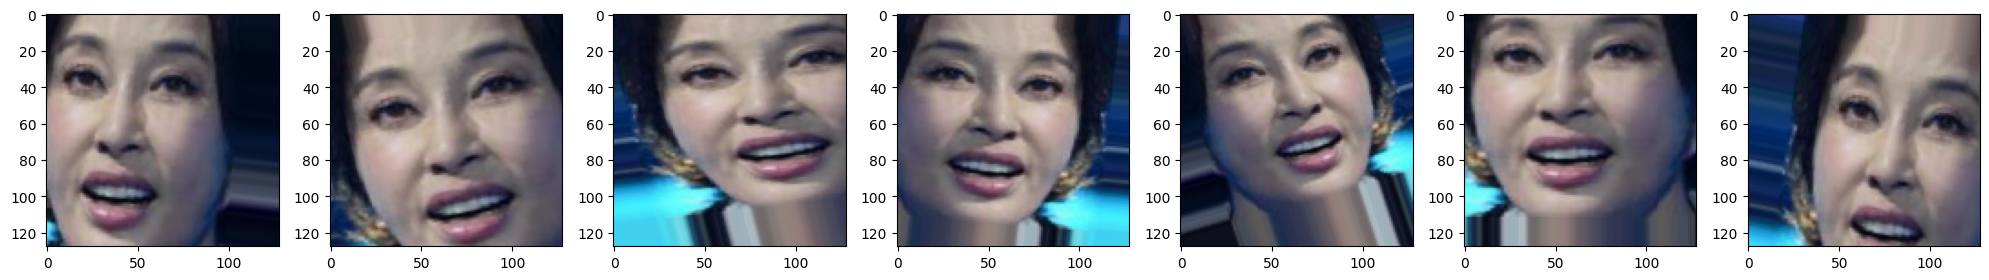

In [139]:
for j in range(7):
    pre_processed_img = [train_generator[0][0][j] for i in range(7)]
plotImages(pre_processed_img)

In [140]:
epochs=30 # model epoch 
input_shape=(img_width, img_height, 3)

In [9]:
# VGGFace model has been used for training 
# Average pooling layers has been used
# Sequential model has been used

vgg_features = VGGFace(include_top=False, input_shape=input_shape, pooling='avg')
model = Sequential()
for i in range(len(vgg_features.layers)-2):
    model.add(vgg_features.layers[i])


for layer in model.layers[:-4]:
    layer.trainable = False

# model.summary()
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(7,activation='softmax'))

model.summary()

2022-11-15 11:43:26.018445: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-15 11:43:26.019366: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-15 11:43:26.088173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2022-11-15 11:43:26.088198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-15 11:43:26.091408: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-15 11:43:26.091474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 128, 128, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 64, 64, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 32, 32, 256)       2

## Custom CNN architecture 

In [141]:
model = Sequential()
model.add(Conv2D(16,(3,3), input_shape=(img_width,img_height,3), activation="relu"))
model.add(Conv2D(32,(3,3), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(64,(3,3), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(128,(3,3), activation="relu"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation="softmax"))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 124, 124, 32)      4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 28, 128)      

In [142]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy'])
checkpoint = ModelCheckpoint('custom/weight_64.hdf5', monitor='val_loss', save_best_only=True)
early_stopping_monitor=EarlyStopping(patience=8, verbose=1)

# hyper parameter tuining with lerarnigng rate

In [45]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

reduce_leraningrate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)

checkpoint = ModelCheckpoint('custom/learning_weight.hdf5', monitor='val_loss', save_best_only=True)
early_stopping_monitor=EarlyStopping(patience=8, verbose=1)

In [143]:
training = model.fit_generator(train_generator, validation_data=validation_generator, 
                               steps_per_epoch=train_generator.samples // batch_size, epochs=epochs, 
#                                validation_steps = validation_generator.samples // 10,
                               callbacks=[checkpoint, early_stopping_monitor])
model.save('custom/learning_model_age.h5')

/home/gpu/anaconda3/envs/vvg16/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
175/175 [==============================] - 55s 309ms/step - loss: 2.0427 - accuracy: 0.1739 - val_loss: 1.8631 - val_accuracy: 0.2321
Epoch 2/30
175/175 [==============================] - 54s 309ms/step - loss: 1.8708 - accuracy: 0.2286 - val_loss: 1.8332 - val_accuracy: 0.2607
Epoch 3/30
175/175 [==============================] - 54s 310ms/step - loss: 1.8175 - accuracy: 0.2720 - val_loss: 1.7671 - val_accuracy: 0.2907
Epoch 4/30
175/175 [==============================] - 54s 310ms/step - loss: 1.7717 - accuracy: 0.2859 - val_loss: 1.7316 - val_accuracy: 0.2986
Epoch 5/30
175/175 [==============================] - 54s 310ms/step - loss: 1.7098 - accuracy: 0.3218 - val_loss: 1.6933 - val_accuracy: 0.3129
Epoch 6/30
175/175 [==============================] - 54s 310ms/step - loss: 1.7013 - accuracy: 0.3274 - val_loss: 1.6212 - val_accuracy: 0.3371
Epoch 7/30
175/175 [==============================] - 54s 309ms/step - loss: 1.6200 - accuracy: 0.3650 - val_loss: 1.6320 - val_ac

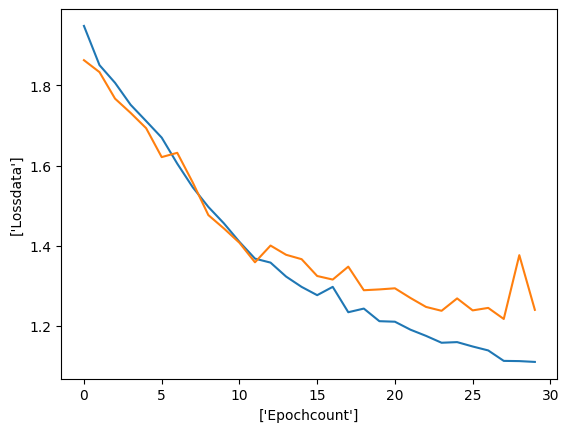

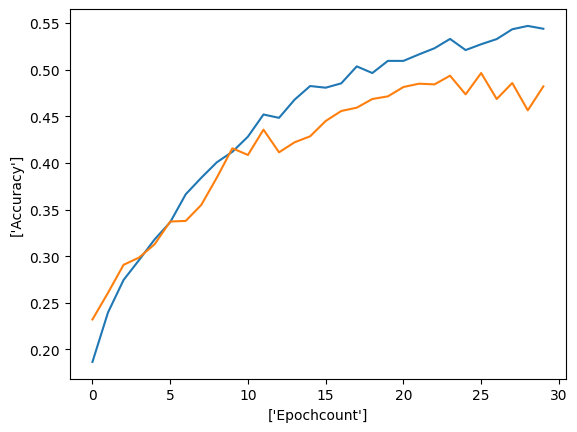

In [144]:
plt.plot(training.history['loss'])
plt.xlabel(['Epochcount'])
plt.plot(training.history['val_loss'])
plt.ylabel(['Lossdata'])
plt.savefig("custom/loss_graph")

plt.show()

plt.plot(training.history['accuracy'])
plt.xlabel(['Epochcount'])
plt.plot(training.history['val_accuracy'])
plt.ylabel(['Accuracy'])
plt.savefig("custom/accuracy_graph")
plt.show()

In [145]:
model.evaluate(validation_generator)

44/44 [==============================] - 5s 117ms/step - loss: 1.2508 - accuracy: 0.4864


[1.2508349418640137, 0.48642855882644653]

In [146]:
y_prediction = model.predict_generator(validation_generator)

/home/gpu/anaconda3/envs/vvg16/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [147]:
y_prediction = np.argmax(y_prediction, axis = 1)

In [148]:
y_prediction

array([0, 0, 0, ..., 6, 1, 0])

In [162]:
y_test=validation_generator.classes
y_test

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [150]:
from sklearn.metrics import confusion_matrix, classification_report
result = confusion_matrix(y_test, y_prediction )

report = classification_report(y_test, y_prediction)

print(report)

              precision    recall  f1-score   support

           0       0.75      0.98      0.85       200
           1       0.42      0.32      0.36       200
           2       0.46      0.34      0.39       200
           3       0.32      0.46      0.37       200
           4       0.24      0.14      0.18       200
           5       0.61      0.46      0.52       200
           6       0.46      0.66      0.54       200

    accuracy                           0.48      1400
   macro avg       0.47      0.48      0.46      1400
weighted avg       0.47      0.48      0.46      1400



In [151]:
with open("custom/classification_report.tzt","w") as writer:
    writer.write(report)

In [152]:

from sklearn import metrics



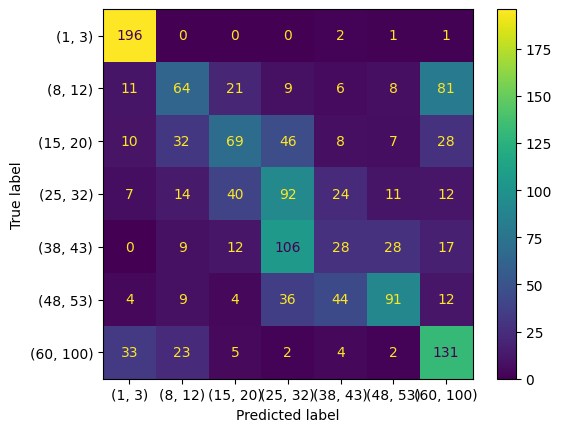

In [153]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [str(i) for i in class_list])

cm_display.plot()
plt.savefig("custom/confusion_matrix")
plt.show()